# Unsupervised Learning: Clustering Lab





In [33]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import numpy.ma as ma
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---

In [104]:
class HACClustering(BaseEstimator, ClusterMixin):
    
    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        #construct distance matrix & clusters & opt metrics
        A = np.array([la.norm(X - val, axis=1) for val in X])
        self.clusters = dict(enumerate([[val] for val in X]))
        opt = np.min if self.link_type == "single" else np.max
        
        #iterate while num of clusters is greater than k
        while len(self.clusters) > self.k:
            ones = np.diag(np.ones(len(A)))
            x, y = np.unravel_index(np.argmin(ma.MaskedArray(A, ones)), A.shape)
            
            if x == y:
                print(ma.MaskedArray(A, A==0))

            distances = opt(list(zip(A[x], A[y])), axis=1)
            distances[x] = 0
            A[x] = distances
            A[:,x] = distances

            A = np.delete(A, y, axis=1)
            A = np.delete(A, y, axis=0)

            self.clusters[x] += self.clusters[y]
            self.clusters = dict(enumerate([cluster for key, cluster in self.clusters.items() if key != y]))
        
        #organize the data & setup labels
        self.X = self.flatten(self.clusters.values())
        keys = [np.full(len(vals), key) for key, vals in self.clusters.items()]
        self.labels = self.flatten(keys)

        return self
    
    def score(self):
        return silhouette_score(self.X, self.labels)
    
    def clustersizes(self):
        print(*[len(cluster) for cluster in self.clusters.values()])
    
    def flatten(self, m):
        return np.array([val for sublist in m for val in sublist])
    
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print(f"Number of Clusters: {self.k}\n")
        print(f"Silhouette Score: {str(self.score())[:6]}\n\n")
        for cluster in self.clusters.values():
            centroid = np.mean(np.array(cluster), axis=0)
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:d}\n".format(len(cluster)))

### 1.1.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735819)

[Debug HAC Complete (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735820)

In [105]:
# Debug Here
#load in abalone data
abalone = arff.loadarff("abalone.arff")
abalone_np = np.array(abalone[0].tolist())
as_np = MinMaxScaler().fit_transform(abalone_np)  #scaled abalone np

#single link
hac = HACClustering(5, link_type="single")
hac.fit(as_np).print_clusters()

#complete link
hac = HACClustering(5, link_type="complete")
hac.fit(as_np).print_clusters()

Number of Clusters: 5

Silhouette Score: 0.3452


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1

Number of Clusters: 5

Silhouette Score: 0.3095


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [88]:
# Load evaluation data
seismic = arff.loadarff("seismic-bumps_train.arff")
seismic_np = np.array(seismic[0].tolist())
ssnp = MinMaxScaler().fit_transform(seismic_np) #scaled seismic np

# Train on evaluation data using complete link
hac = HACClustering(5, link_type="complete")
hac.fit(ssnp)

# Print clusters
hac.print_clusters()


Number of Clusters: 5

Silhouette Score: 0.2929999090830462


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### 1.1.3.1 Single Link

In [89]:
# Load evaluation data
seismic = arff.loadarff("seismic-bumps_train.arff")
seismic_np = np.array(seismic[0].tolist())
ssnp = MinMaxScaler().fit_transform(seismic_np) #scaled seismic np

# Train on evaluation data using single link
hac = HACClustering(5, link_type="single")
hac.fit(ssnp)

# Print clusters
hac.print_clusters()


Number of Clusters: 5

Silhouette Score: 0.39713760070608084


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [108]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        #construct initial centroids
        initial = X[:self.k] if self.debug else np.random.random((self.k, len(X[0])))
        self.centroids = dict(enumerate(initial))
        max_iter = 2500
        tol = 1e-4

        #iterate through max_iter
        for i in range(max_iter):
            #compute the clusters
            dists = np.array([la.norm(list(self.centroids.values()) - x, axis=1) for x in X])
            mins = np.argmin(dists, axis=1)
            self.clusters = {j: [] for j in range(self.k)}

            for j, val in enumerate(X):
                self.clusters[mins[j]].append(val)
            
            previous = dict(self.centroids)            
    
            for k, cluster in self.clusters.items():
                if len(cluster) <= 0:
                    self.centroids[k] = np.random.random(len(X[0]))
                else:
                    self.centroids[k] = np.mean(cluster, axis=0)

            
            #check if centroids have moved significantly
            convergence = True
            for centroid in self.centroids:

                if la.norm(previous[centroid] - self.centroids[centroid]) > tol:
                    convergence = False
                    break
            #break if converges
            if convergence:
                break
        
        #assign X & the labels
        self.X = self.flatten(self.clusters.values())
        keys = [np.full(len(vals), key) for key, vals in self.clusters.items()]
        self.labels = self.flatten(keys)
        
        return self
    
    def flatten(self, metalist):
        #function to flatten
        return np.array([val for sublist in metalist for val in sublist])

    def score(self):
        #function to return silhouette score
        return silhouette_score(self.X, self.labels)
    
    def clustersizes(self):
        #prints cluster sizes
        print(*[len(cluster) for cluster in self.clusters.values()])
    

    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print(f"Number of Clusters: {self.k}\n")
        print(f"Silhouette Score: {str(self.score())[:6]}\n\n")

        for cluster in self.clusters.values():
            centroid = np.mean(np.array(cluster), axis=0)
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:d}\n".format(len(cluster)))

### 1.2.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735840)

In [109]:
# Load debug data
abalone = arff.loadarff("abalone.arff")
abalone_np = np.array(abalone[0].tolist())
abalone_scaled_np = MinMaxScaler().fit_transform(abalone_np)

# Train on debug data
kmeans = KMEANSClustering(5, debug=True)
kmeans.fit(abalone_scaled_np)

# Print clusters
kmeans.print_clusters()


Number of Clusters: 5

Silhouette Score: 0.3845


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [110]:
# Load evaluation data
seismic = arff.loadarff("seismic-bumps_train.arff")
seismic_np = np.array(seismic[0].tolist())
ssnp = MinMaxScaler().fit_transform(seismic_np) #scaled seismic np

# Train on evaluation data
kmeans = KMEANSClustering(5, debug=True)
kmeans.fit(ssnp)

# Print clusters
kmeans.print_clusters()

Number of Clusters: 5

Silhouette Score: 0.2769


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

50 100
49 1 100
49 1 98 2
49 1 97 1 2
49 1 96 1 1 2
49 1 95 1 1 1 2


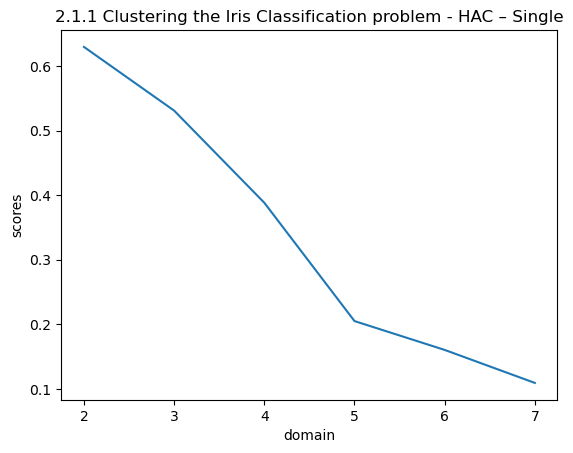

In [113]:
# Iris Classification using single-link
#load data
iris = arff.loadarff("iris.arff")

# Encode classes
iris_df = pd.DataFrame(iris[0])
iris_df["class"] = LabelEncoder().fit_transform(iris_df["class"])
iris_np = iris_df.to_numpy()
isnp = MinMaxScaler().fit_transform(iris_np)  #scaled iris np

dom = np.arange(2, 8)
scores = []

for k in dom:
    hac = HACClustering(k, link_type="single")
    hac.fit(isnp[:,:-1])
    scores.append(hac.score())
    hac.clustersizes()
#plot
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.1.1 Clustering the Iris Classification problem - HAC – Single')
plt.show()

116 34
50 66 34
33 17 66 34
33 17 37 29 34
33 17 37 29 23 11
33 17 23 29 14 23 11


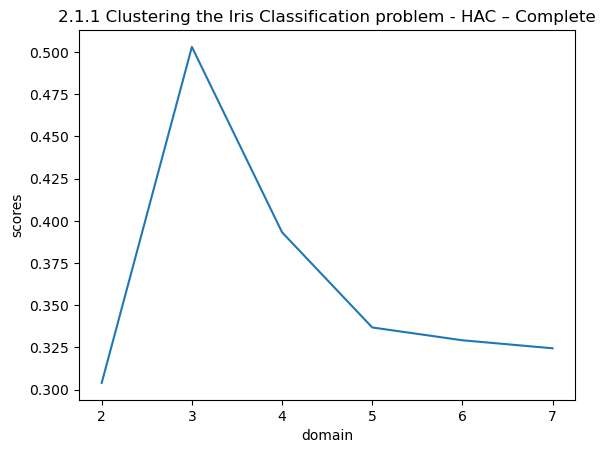

In [116]:
# Iris Classification using complete-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="complete")
    hac.fit(isnp[:,:-1])
    scores.append(hac.score())
    hac.clustersizes()
#plot
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.1.1 Clustering the Iris Classification problem - HAC – Complete')
plt.show()

#### Discuss differences between single-link and complete-link
##### We see a much higher accuracy in the single link model when we don't include the classes as well as more variance in the shape/behavior of the plots. For example when k=2, we have the single link performing it's best, whereas the complete link has it's lowest scores.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

50 100
50 50 50
50 50 49 1
49 1 50 49 1
49 1 50 47 1 2
49 1 50 46 1 2 1


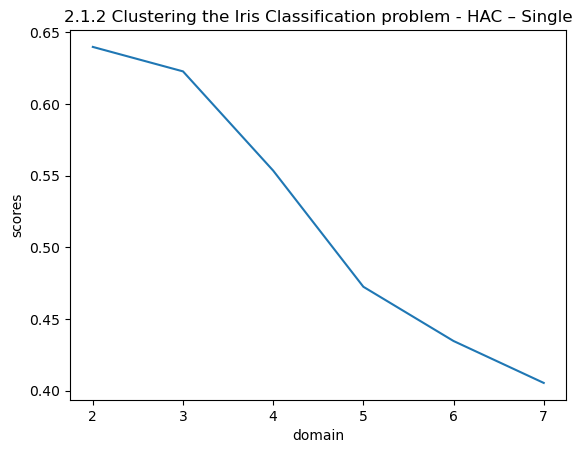

In [117]:
# Clustering Labels using single-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="single")
    hac.fit(isnp)
    scores.append(hac.score())
    hac.clustersizes()
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.1.2 Clustering the Iris Classification problem - HAC – Single')
plt.show()

50 100
50 70 30
33 17 70 30
33 17 50 30 20
33 17 21 29 30 20
33 17 21 29 19 20 11


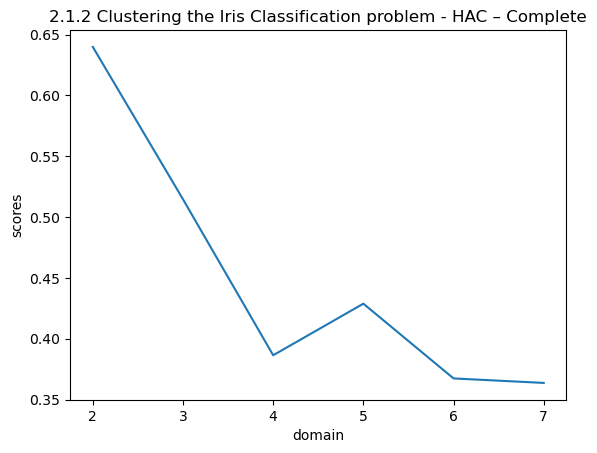

In [120]:
# Clustering Labels using complete-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="complete")
    hac.fit(isnp)
    scores.append(hac.score())
    hac.clustersizes()
#plot
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.1.2 Clustering the Iris Classification problem - HAC – Complete')
plt.show()

#### Discuss any differences between the results from 2.1.1 and 2.1.2.

##### When we included the classes, both models improved their performance. We see the biggest difference in the graph of the complete link as it generally peaks when k is equal to 2–similar to the single link graph– and goes down from there. On the other side, the single link returned clusters 


## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

50 100
32 22 96
50 30 43 27
40 50 29 20 11
36 11 27 26 36 14
18 20 25 40 29 11 7


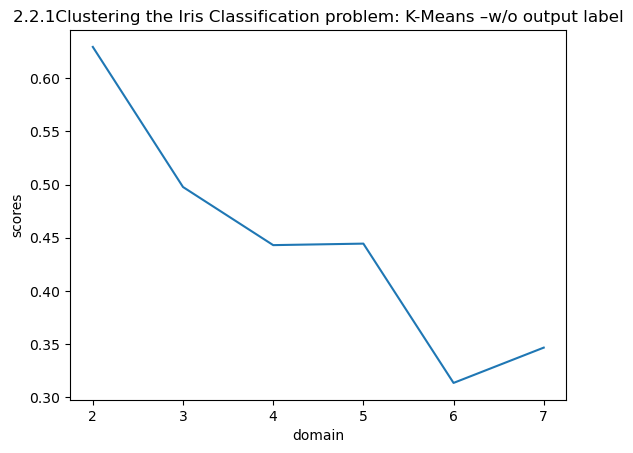

In [123]:
# Iris Classification without output label
scores = []
for k in dom:
    kmeans = KMEANSClustering(k)
    kmeans.fit(isnp[:,:-1])
    scores.append(kmeans.score())
    kmeans.clustersizes()
#plot
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.2.1Clustering the Iris Classification problem: K-Means –w/o output label')
plt.show()


100 50
50 50 50
50 27 23 50
27 28 22 50 23
14 16 36 50 23 11
24 16 28 22 23 26 11


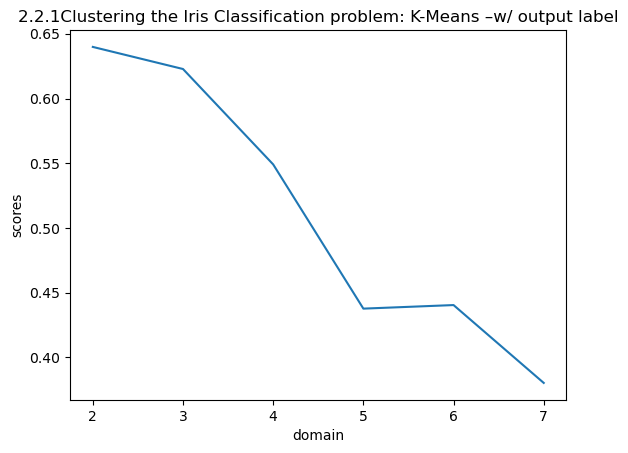

In [124]:
# Iris Classification with output label
scores = []
for k in dom:
    kmeans = KMEANSClustering(k)
    kmeans.fit(isnp)
    scores.append(kmeans.score())
    kmeans.clustersizes()
#plot
plt.plot(dom, scores)
plt.xlabel('domain')
plt.ylabel('scores')
plt.title('2.2.1Clustering the Iris Classification problem: K-Means –w/ output label')

plt.show()

#### Compare results and differences between using the output label and excluding the output label

##### Both graphs produce are similar graphs, however when we include the class, we find the best score increases with the class. 

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

50 50 14 36
27 23 50 50
50 23 50 27
50 27 50 23
50 24 26 50


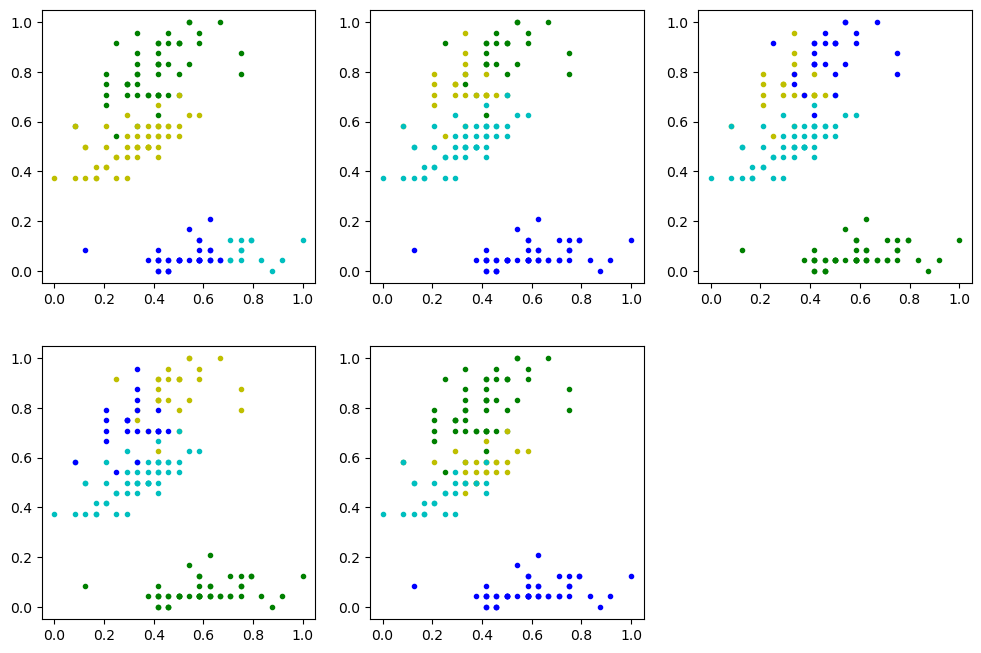

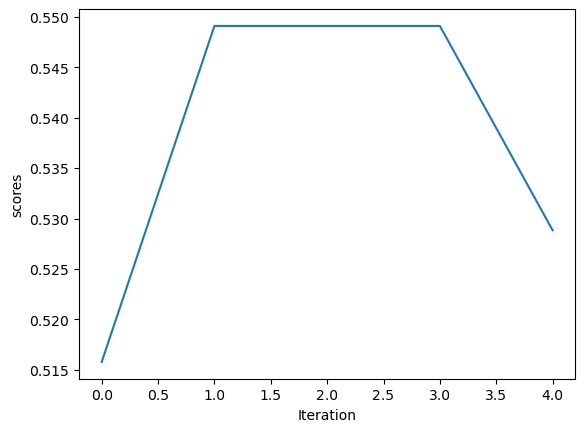

In [148]:
#K-Means 5 times
scores = []
plt.figure(figsize=(12, 8))
colors = ["g.", "y.", "c.", "b."]

for i in range(5):
    plt.subplot(2, 3, i+1)
    #construct kmeans clustering
    kmeans = KMEANSClustering(4)
    kmeans.fit(isnp)
    
    for j, X in kmeans.clusters.items():

        x, y = np.array(X)[:,[1, 3]].T
        
        #plot
        plt.gca().set_aspect("equal")
        plt.plot(x, y, colors[j])
  
    scores.append(kmeans.score())
    kmeans.clustersizes()
plt.show()
plt.plot(scores)
plt.ylabel('scores')
plt.xlabel('Iteration')
plt.show()

#### Discuss any variations in the results

##### The results, from how they cluster to the scores, vary a lot. It's hard to find a significant pattern.


## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

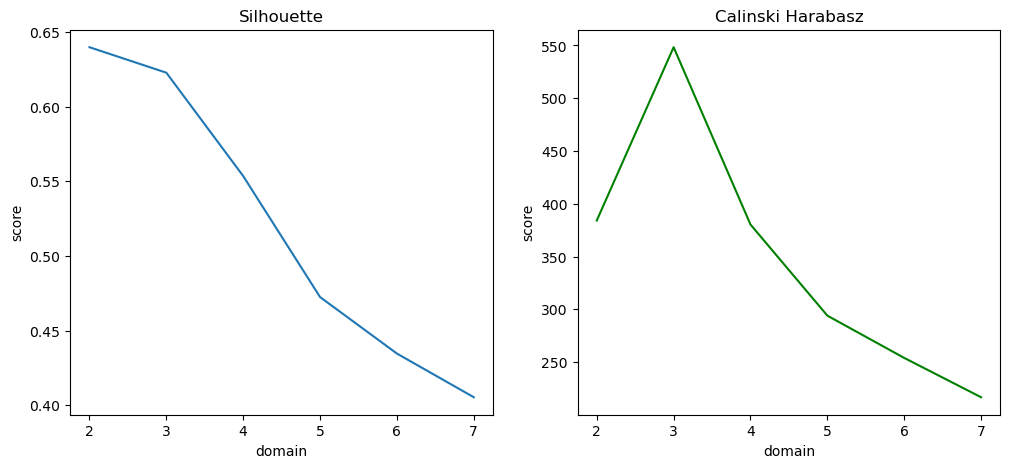

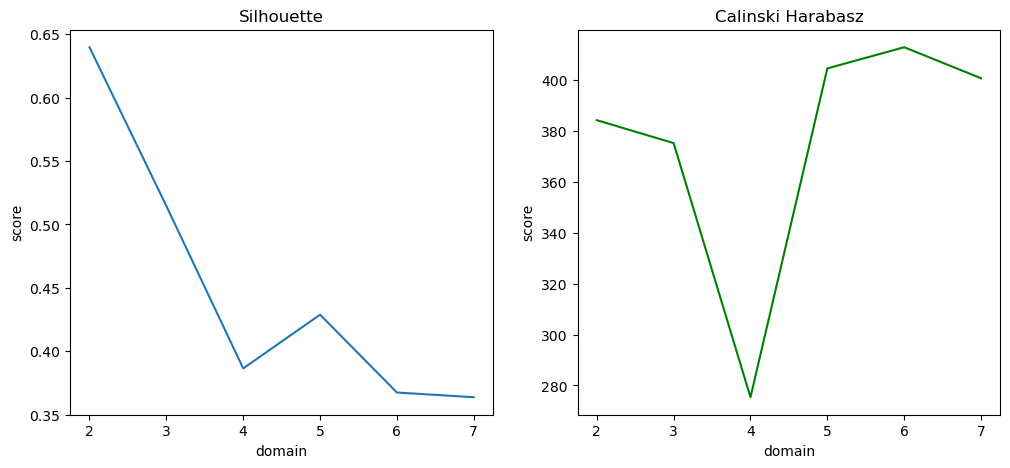

0.6398447268887528
0.47886050421178256


/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [140]:
# Load sklearn
sil, cal = [], []
for k in dom:
    #construct single hac
    hac = AgglomerativeClustering(n_clusters=k, linkage="single")
    y = hac.fit_predict(isnp)
    sil.append(silhouette_score(isnp, y))
    cal.append(calinski_harabasz_score(isnp, y))

#plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.xlabel('domain')
plt.ylabel('score')
plt.title('Silhouette')

plt.subplot(1, 2, 2)
plt.plot(dom, cal, label="calinski harabasz", c='g')
plt.title('Calinski Harabasz')
plt.xlabel('domain')
plt.ylabel('score')
plt.show()

#get clustering labels using complete-link
sil, cal = [], []
for k in dom:
    #construct complete hac
    hac = AgglomerativeClustering(n_clusters=k, linkage="complete")
    y = hac.fit_predict(isnp)
    sil.append(silhouette_score(isnp, y))
    cal.append(calinski_harabasz_score(isnp, y))

#plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.title('Silhouette')
plt.xlabel('domain')
plt.ylabel('score')


plt.subplot(1, 2, 2)
plt.plot(dom, cal, label="calinski harabasz", c='g')
plt.title('Calinski Harabasz')
plt.xlabel('domain')
plt.ylabel('score')
plt.show()

hac = AgglomerativeClustering(n_clusters=2, affinity="cosine", linkage="average")
y = hac.fit_predict(isnp)
print(silhouette_score(isnp, y))
hac = AgglomerativeClustering(n_clusters=2, affinity="l1", linkage="complete")
y = hac.fit_predict(isnp)
print(silhouette_score(isnp, y))


#### *Record impressions*
##### I used a different scoring function and I found that sihouette worked best for choosing the optimal clustering. I compared it to the Calinski Harabasz metric. I discovered that the worst metric was the l2 distance metric.

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brynnwoolley/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

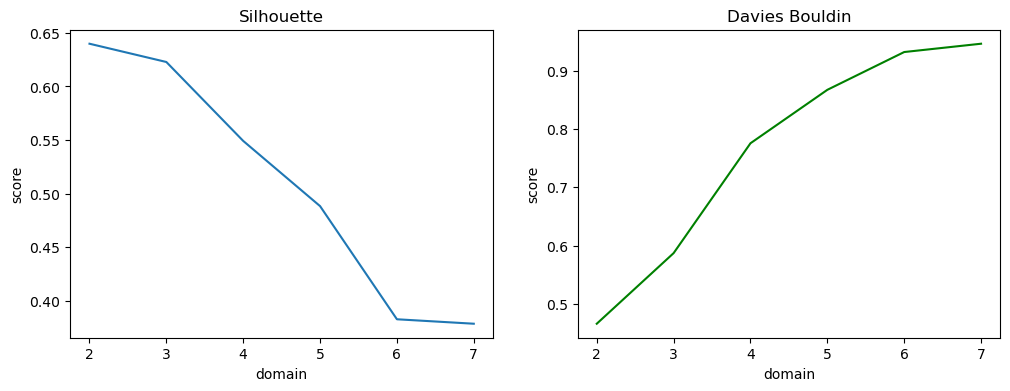

0.6398447268887528
0.6398447268887528


In [139]:
# Load sklearn 
sil, dav = [], []

for k in dom:
    #kmeans 
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit_predict(isnp)
    sil.append(silhouette_score(isnp, y))
    dav.append(davies_bouldin_score(isnp, y))

#plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.title('Silhouette')
plt.xlabel('domain')
plt.ylabel('score')

plt.subplot(1, 2, 2)
plt.plot(dom, dav, label="davies bouldin", c='g')
plt.title('Davies Bouldin')
plt.xlabel('domain')
plt.ylabel('score')
plt.show()


kmeans = KMeans(n_clusters=2, init="random", n_init=1)
y = kmeans.fit_predict(isnp)
print(silhouette_score(isnp, y))
kmeans = KMeans(n_clusters=2, init="random", n_init=100)
y = kmeans.fit_predict(isnp)
print(silhouette_score(isnp, y))


#### *Record impressions*

##### Again, I used a silhouette scoring function other than my own, but the silhoutte function was good at choosing what optimal k to pick. Beyond that, I found, as seen in the plots, that the worse the clustering the lower the silhoueete scores. I then compared it to the Davies Bouldin scoring function. I also tried seeing what happened if I had an algorithm construct random centroids, but it didn't seem to affect the sihoutte score significantly.

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [50]:
# Copy function Below